

# Implementación Q-Learning

**Ejemplo: Frozen Lake**

Este desarrollo implementa un algoritmo Q-learning aplicado al entorno [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) con diferentes tamaños de mapa, más entornos para RL pueden ser encontrados en  [Gymnasium](https://gymnasium.farama.org/) .

Se definen los métodos a utilizar para el entrenamiento y visualización.


## Dependencias

Primero se importan las dependencias necesarias para el manejo de arreglos, tuplas, graficación y entornos

In [40]:
#hide
from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

!pip install renderlab
!pip install gymnasium
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

sns.set_theme()

# %load_ext lab_black

## Parámetros para el algoritmo

Los hiperparaámetros para este algoritmo son la razón de aprendizaje para la actualización de la tabla-Q $Q(s,a)$, la razón de descuento para el cálculo del retorno $G_t$ y el retorno esperado y $/epsilon$ para la exploración-explotación.

In [41]:
class Params(NamedTuple):
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability

    total_episodes: int  # Total episodes
    map_size: int  # Number of tiles of one side of the squared environment
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states

    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved

params = Params(
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,

    total_episodes=2000,
    map_size=5,
    action_size=None,
    state_size=None,

    seed=123,
    is_slippery=False,
    n_runs=20,
    proba_frozen=0.9,
    savefig_folder=Path("img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

## Creación de la tabla-Q

en base al algoritmo Q-learning como nuestro algoritmo de aprendizaje y el algoritmo $\epsilon$-greedy para decidir que acción realizar en cada paso.

Se crea una tabla-Q inicializada con ceros con el número de estados como renglones y el número de acciones como columnas.

quicklatex.com-146067a08e0923757c6fa7e595b3e0ab_l3.svg

In [42]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()
    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update
    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))

Action size: 4
State size: 121


quicklatex.com-5b10393cf0c6395ae5fb22260220c574_l3.svg

In [43]:
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon
    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

## Visualización

### Función para convertir a Dataframe
Se utiliza Seaborn para graficar los resultados de simulación en dataframes de Panda.

In [44]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])
    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

### Función para convertir las mejores acciones en flechas
Objetivo: Graficar la pólitica del agente ya entrenado.
1. extraer los mejores valores-Q desde la tabla-Q para cada estado
2. obtener la acción (la mejor) correspondiente a cada valor-Q
3. Mapear cada accción con su correspondiente flecha para visualización

In [45]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

### Función para graficar los mejores valores-Q

Se grafica el último frame de simulación.

Si el agente aprendió una buena política para resolver la tarea, se espera ver esto en el estado final (tesoro).

El heatmap muestra el valor-Q aprendido para cada estado (es decir la política)

Las flechas representan la mejor acción para cada estado.


In [46]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    plt.figure(figsize=(7,5))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

### Función para graficar las distribuciones de los estados y acciones

In [47]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}
    plt.figure(figsize=(5,3))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

### Función para graficar recompensas y pasos

Para revisar si nuestro agente esta aprendiendo, se puede graficar la recompensa acumulada (retorno) y el número de pasos necesarios hasta el final de episodio.

Si el agente esta aprendiendo, se espera que la recompensa acumulada se incremente y el número de paso para resolver la tarea vaya en decremento.

In [48]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""

    plt.figure(figsize=(3,2))
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")
    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")
    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

# Ejecución principal

## 1. Entorno FrozenLake

Action Space: Discrete(4)

Observation Space: Discrete(16)

Max Episode Steps: 100

Nondeterministic: False

Reward Range: (0, 1)

Reward Threshold: 0.7


In [49]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

## 2. Inicio del algoritmo (Agente)$\epsilon$-Greedy Q-Learning

Se inicializan las instancias del aprendiz y la exploración $\epsilon$-greedy


In [50]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

##Función principal

Ejecutar el entrenamiento del aprendiz por el algoritmo de Q-learning. Esta se ejecuta ``n_runs`` veces con propósito estocástico.

In [51]:
def run_env():

    # Parameters of all episodes
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []
    episodes = np.arange(params.total_episodes)

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs (always)
        for episode in tqdm(   # Show status bar
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0
            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )
                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)
                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )
                total_rewards += reward
                step += 1
                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable
    return rewards, steps, episodes, qtables, all_states, all_actions

# Evaluación del agente para diferentes tamaños de mapa

Se realiza la evaluación para mapas de 4x4, 7x7, 9x9, 11x11

In [52]:
map_sizes = [4, 7, 9, 11]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

Map size: 4x4


<Figure size 500x300 with 0 Axes>

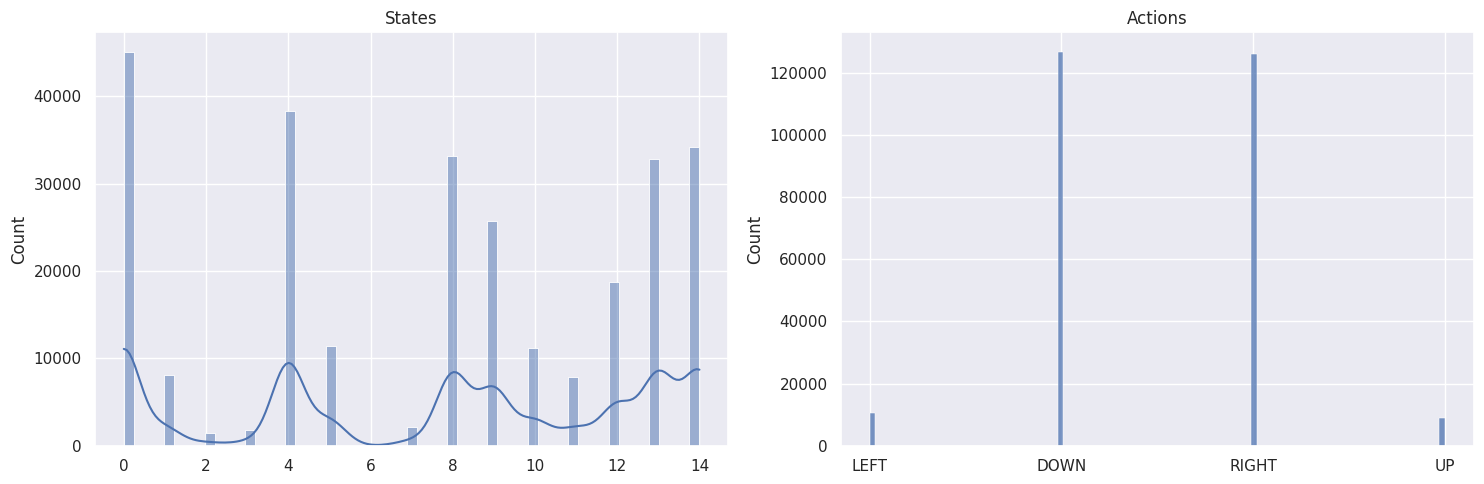

<Figure size 700x500 with 0 Axes>

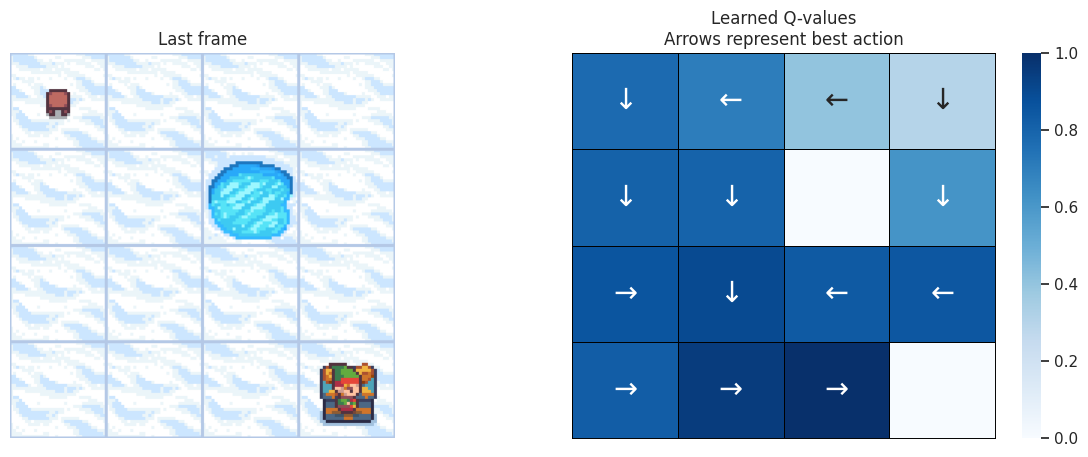

Map size: 7x7


<Figure size 500x300 with 0 Axes>

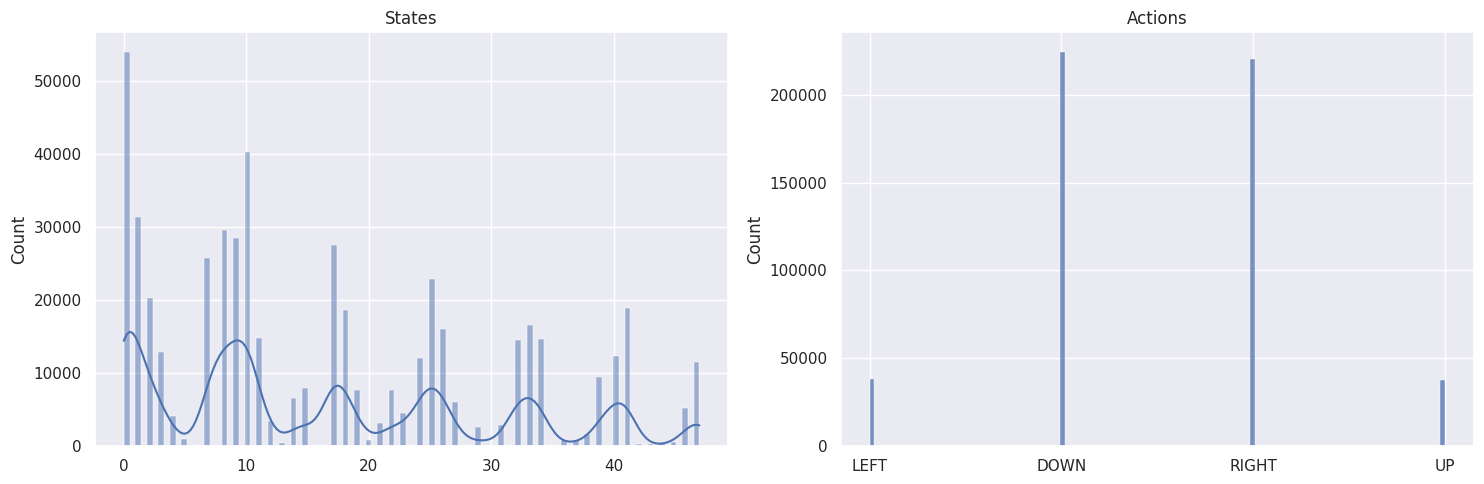

<Figure size 700x500 with 0 Axes>

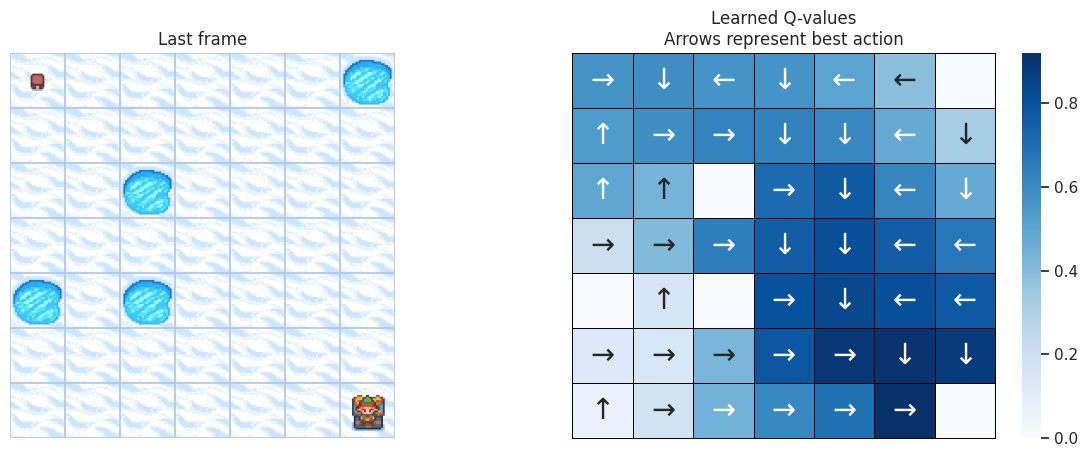

Map size: 9x9


<Figure size 500x300 with 0 Axes>

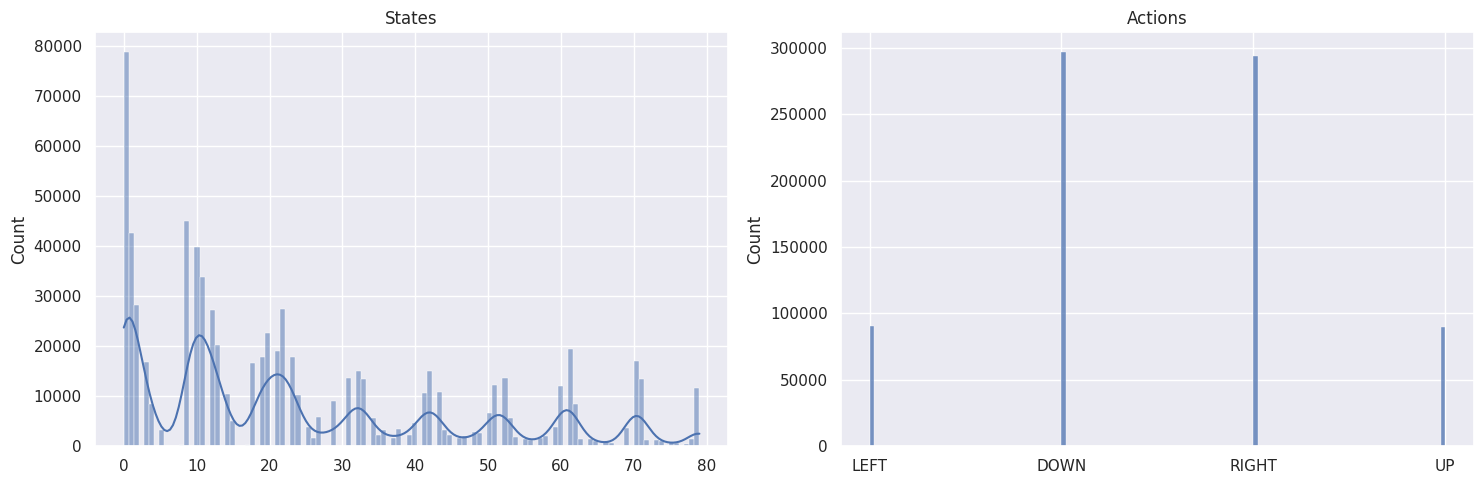

<Figure size 700x500 with 0 Axes>

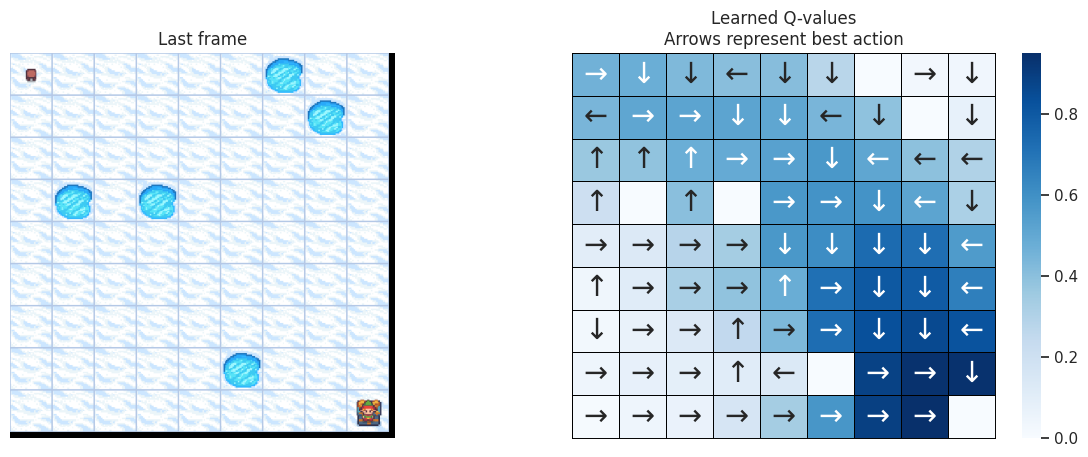

Map size: 11x11


<Figure size 500x300 with 0 Axes>

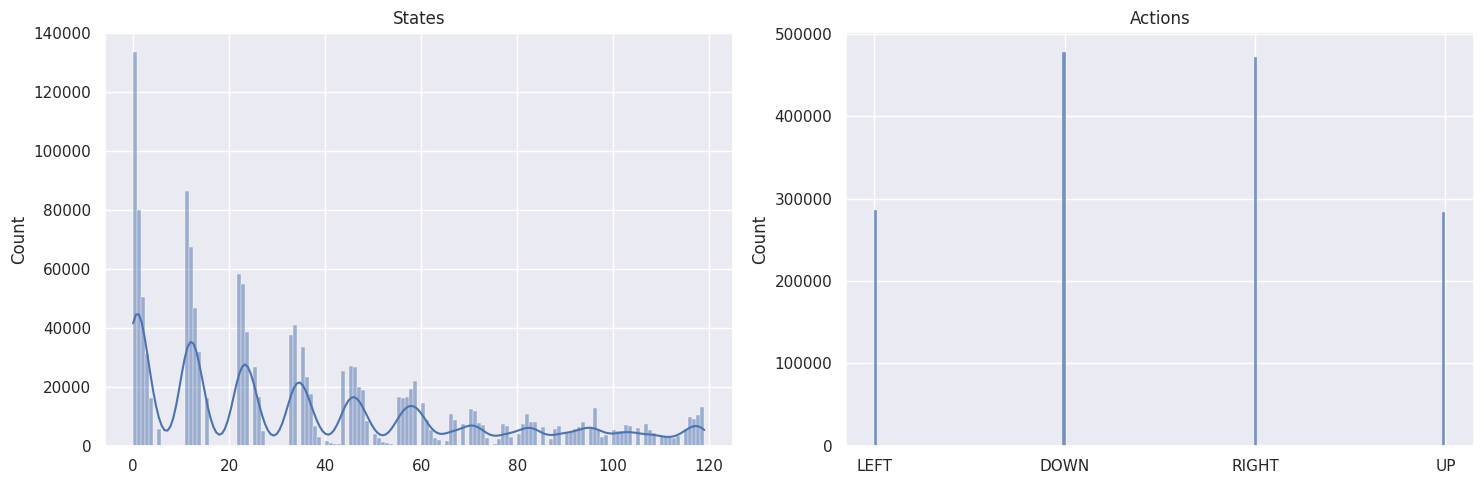

<Figure size 700x500 with 0 Axes>

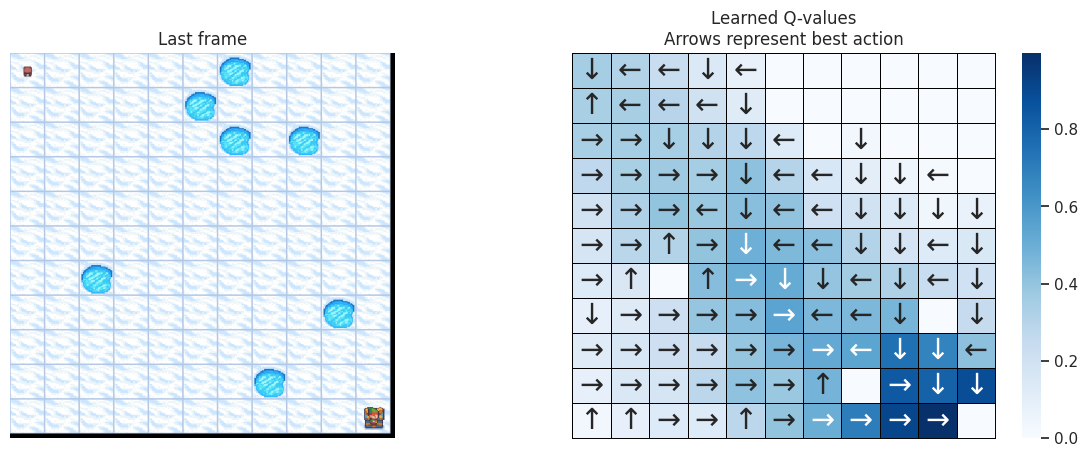

In [53]:
for map_size in map_sizes:
    # 1. Initialize enviroment
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )
    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)

    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space

    # Initialize the agent and epsilon-greedy
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs
    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)
    env.close()

La derecha y abajo son las acciones más realizadas, esto hace sentido ya que el agente inicia en la esquina superior izquierda y necesita encontrar el tesoro a la derecha.

Entre más grande es el mapa los estados más alejados del inicio son menos visitados.

<Figure size 300x200 with 0 Axes>

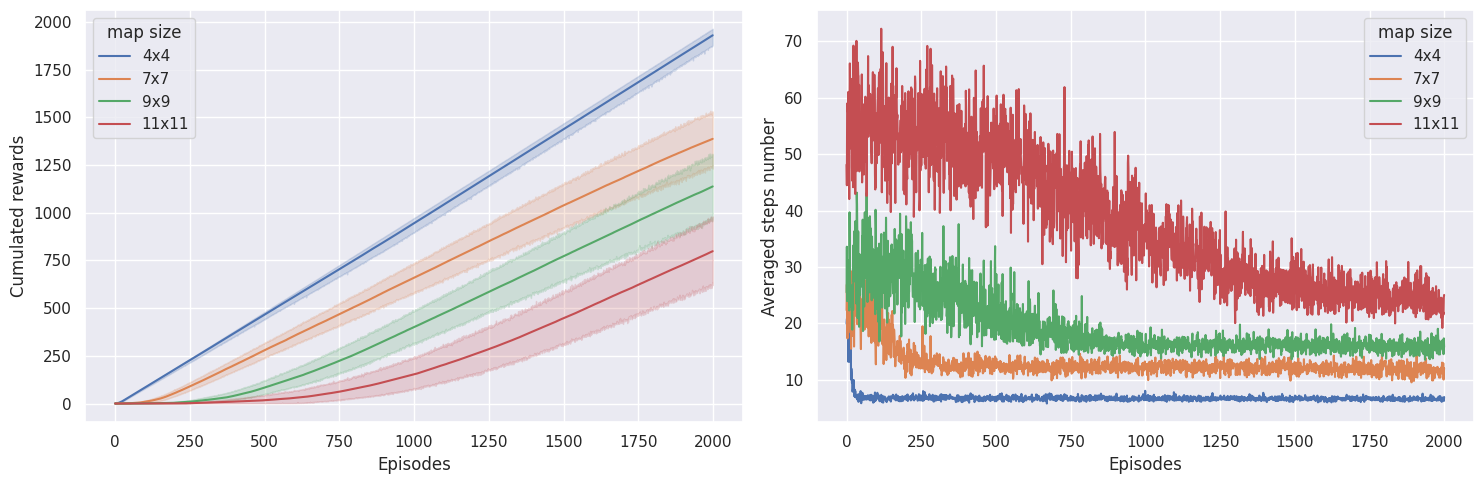

In [54]:
plot_steps_and_rewards(res_all, st_all)

## Discusiones

Al final, si el agente no consigue alguna recompensa, estas no se pueden propagar a los valores-Q, y el agente no aprenderá algo.

Prueba a modificar ``proba_frozen`` con un valor más bajo, este aumenta el número de hoyos y dificulta conseguir recompensa para actualizar la tabla-Q.

Prueba también a aumentar o disminuir la razón de descuento y evalua los resultados.

# Referencias

-  Code inspired from [Deep Reinforcement Learning
   Course](https://simoninithomas.github.io/Deep_reinforcement_learning_Course/)_
   by Thomas Simonini (http://simoninithomas.com/)
-  [Dissecting Reinforcement
   Learning-Part.2](https://mpatacchiola.github.io/blog/2017/01/15/dissecting-reinforcement-learning-2.html)_
-  [Dadid Silver’s course](https://www.davidsilver.uk/teaching/)_ in
   particular lesson 4 and lesson 5
-  [Q-learning article on
   Wikipedia](https://en.wikipedia.org/wiki/Q-learning)_
-  [Q-Learning: Off-Policy TD
   Control](http://incompleteideas.net/book/ebook/node65.html)_ in
   [Reinforcement Learning: An Introduction, by Richard S. Sutton and
   Andrew G. Barto](http://incompleteideas.net/book/ebook/)_
-  [Epsilon-Greedy
   Q-learning](https://www.baeldung.com/cs/epsilon-greedy-q-learning)_
-  [Introduction to Reinforcement
   Learning](https://gibberblot.github.io/rl-notes/index.html)_ by Tim
   Miller (University of Melbourne)


